# Soft Actor Critic (SAC) Notebook

## Install PyBullet for Physics based environments

In [1]:
! pip install pybullet

     |████████████████████████████████| 90.8 MB 264 bytes/s 


## Clone the Repository

In [4]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/SAC_with_PyTorch
# add path to .py files for import
import sys
sys.path.insert(1, "/content/SAC_with_PyTorch/src")

Cloning into 'SAC_with_PyTorch'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 123 (delta 45), reused 80 (delta 17), pack-reused 0
Receiving objects: 100% (123/123), 3.25 MiB | 38.72 MiB/s, done.
Resolving deltas: 100% (45/45), done.


## Get imports

In [6]:
import os
import gym
import numpy as np
import pybullet_envs

from utils import plot_learning_curve
from agents import Agent

## Set Agent + Env arguments (similar to the command line API from repo's Readme)

In [7]:
env_name = 'InvertedDoublePendulumBulletEnv-v0'
dir = 'tmp'
n_games = 100


gamma = 0.99
alpha = 3e-4
beta = 3e-4
fc1_dim = 256
fc2_dim = 256
memory_size = 100000
batch_size = 256
tau = 0.005
update_period = 2
reward_scale = 2.
warmup = 1000
reparam_noise_lim = 1e-6
play = False
load_checkpoint = False
gpu_to_cpu = False


## Run SAC

/content/SAC_with_PyTorch/src/agents.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  state = T.tensor([state], dtype=T.float).to(self.actor.device)


| Game:      0 | Score:     259.76 | Best score:       -inf | Avg score     259.76 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
| Game:      1 | Score:     287.64 | Best score:     259.76 | Avg score     273.70 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
| Game:      2 | Score:     362.25 | Best score:     273.70 | Avg score     303.21 |
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
... saving checkpoint ...
| Game:      3 | Score:     269.00 | Best score:     303.21 | Avg score     294.66 |
| Game:      4 | Score:     288.09 | Best score:     303.21 | Avg score     293.35 |
| Game:      5 | Score:     324.96 | Best score:     303.21 | Avg score     298.62 |
| Game:      6 | Score:     287.88 | Best score:     303.21 | Avg score     297.08 |
| Game:      7 

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


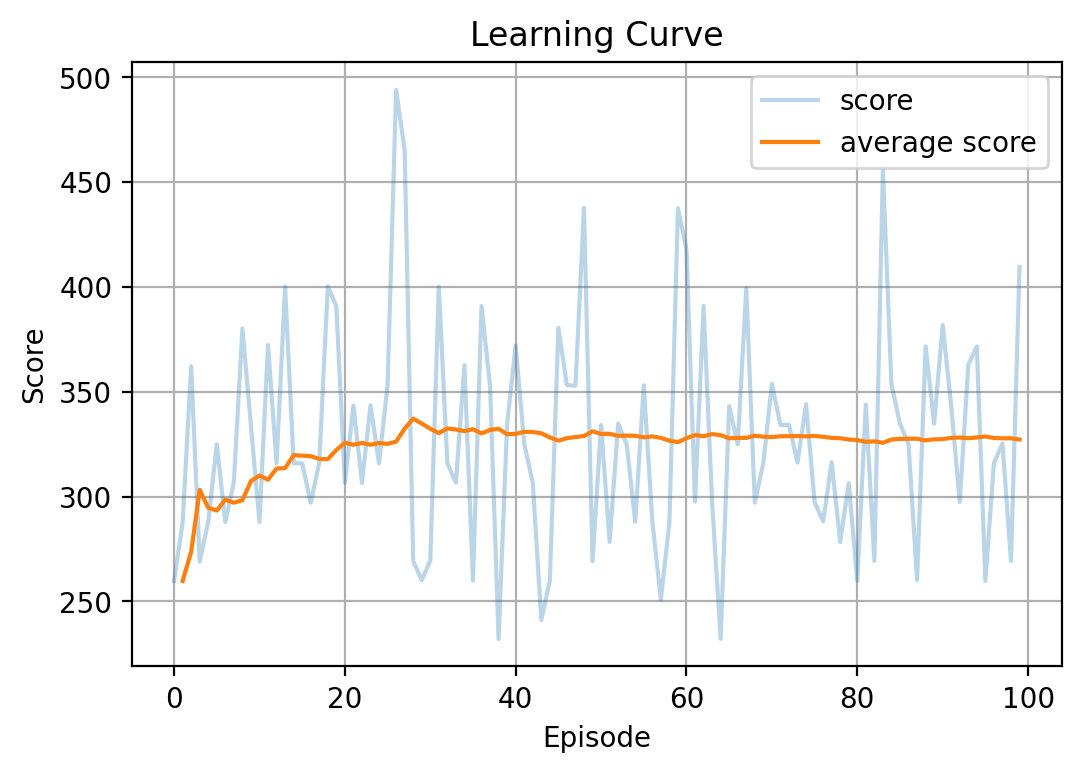

In [12]:
env = gym.make(env_name)
dir_path = os.path.join(dir, env_name)
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

agent = Agent(gamma=gamma, alpha=alpha, beta=beta, state_dims=env.observation_space.shape,
              action_dims=env.action_space.shape, max_action=env.action_space.high[0],
              fc1_dim=fc1_dim, fc2_dim=fc2_dim, memory_size=memory_size,
              batch_size=batch_size, tau=tau, update_period=update_period,
              reward_scale=reward_scale, warmup=warmup, reparam_noise_lim=reparam_noise_lim,
              name='SAC_'+env_name, ckpt_dir=dir_path)

scores, avg_scores = [], []
best_score = -np.inf

if play:
    # env.render(mode='human') (cannot render in colab)
    pass

if load_checkpoint:
    agent.load_model(gpu_to_cpu=gpu_to_cpu)

for game in range(n_games):
    observation = env.reset()
    done = False
    score = 0

    while not done:
        if play:
            action = agent.choose_action(observation, deterministic=True, reparameterize=False)
        else:
            action = agent.choose_action(observation, deterministic=False, reparameterize=False)
        observation_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(observation, action, reward, observation_, done)
        if not play:
            agent.learn()
        observation = observation_
    scores.append(score)
    avg_score = np.mean(scores[-100:])
    avg_scores.append(avg_score)

    print(f'| Game: {game:6.0f} | Score: {score:10.2f} | Best score: {best_score:10.2f} | '
          f'Avg score {avg_score:10.2f} |')

    if avg_score > best_score:
        best_score = avg_score
        if not play:
            agent.save_model()
env.close()

if not play:
    plot_learning_curve(scores, agent.full_path)
